In [28]:
from __init__ import *
import utils as _U
reload(_U)
import dataset as _D
reload(_D)
import model as _M
reload(_M)
import train as _T
reload(_T)
import test as _TE
reload(_TE)
import inference as _I
reload(_I)

<module 'inference' from '/root/CNN-for-Trading/inference.py'>

## Training Settings

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open('configs/I20R5/I20R5_09-11.yml', 'r') as f:
    setting = _U.Dict2ObjParser(yaml.safe_load(f)).parse()

In [4]:
if 'models' not in os.listdir('./'):
    os.system('mkdir models')
if setting.TRAIN.MODEL_SAVE_FILE.split('/')[1] not in os.listdir('./models/'):
    os.system(f"cd models && mkdir {setting.TRAIN.MODEL_SAVE_FILE.split('/')[1]}")
if 'logs' not in os.listdir('./'):
    os.system('mkdir logs')
if setting.TRAIN.LOG_SAVE_FILE.split('/')[1] not in os.listdir('./logs/'):
    os.system(f"cd logs && mkdir {setting.TRAIN.LOG_SAVE_FILE.split('/')[1]}")

## Train & Valid

### Dataset Preparation

In [5]:
train_dataset = _D.ImageDataSet(win_size = setting.DATASET.LOOKBACK_WIN, \
                            start_date = setting.DATASET.START_DATE, \
                            end_date = setting.DATASET.END_DATE, \
                            mode = 'train', \
                            label = setting.TRAIN.LABEL, \
                            indicators = setting.DATASET.INDICATORS, \
                            show_volume = setting.DATASET.SHOW_VOLUME, \
                            parallel_num=setting.DATASET.PARALLEL_NUM)

[Load Data] | 2023-04-24 03:01:49 Done | Using  9.858 seconds
DataSet Initialized
 	 - Mode:         DEFAULT
 	 - Image Size:   (64, 60)
 	 - Time Period:  20091231 - 20111231
 	 - Indicators:   [('MA', ['20'])]
 	 - Volume Shown: True


In [6]:
image_set = train_dataset.generate_images(setting.DATASET.SAMPLE_RATE)

Generating Images (sample rate: 0.0001): 100%|██████████| 2283/2283 [00:26<00:00, 84.61it/s] 


LABEL: RET5
Resampled ImageSet: 0: 50/100, 1: 50/100


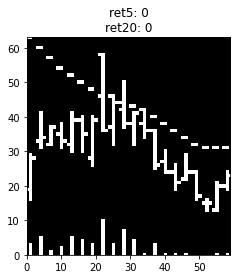

In [7]:
# preview of the "image" (np.array)
_U.display_image(image_set[69])

In [9]:
train_loader_size = int(len(image_set)*(1-setting.TRAIN.VALID_RATIO))
valid_loader_size = len(image_set) - train_loader_size

train_loader, valid_loader = torch.utils.data.random_split(image_set, [train_loader_size, valid_loader_size])
train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)

### Model Structure

In [12]:
model_d20 = _M.CNN20d()
model_d20.to(device)

CNN20d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (Conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5

### Training Process

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_d20.parameters(), lr=setting.TRAIN.LEARNING_RATE, weight_decay=setting.TRAIN.WEIGHT_DECAY)

In [14]:
train_loss_set, valid_loss_set, train_acc_set, valid_acc_set = _T.train_n_epochs(setting.TRAIN.NEPOCH, model_d20, setting.TRAIN.LABEL, train_loader, valid_loader, criterion, optimizer, setting.TRAIN.MODEL_SAVE_FILE, setting.TRAIN.EARLY_STOP_EPOCH)

Epoch: 1 Training Loss: 1.561841 Validation Loss: 1.105527 Training Acc: 0.40000 Validation Acc: 0.53333
Validation loss decreased (inf --> 1.105527).  Saving model ...
Epoch: 2 Training Loss: 1.201167 Validation Loss: 0.931947 Training Acc: 0.48571 Validation Acc: 0.43333
Validation loss decreased (1.105527 --> 0.931947).  Saving model ...
Epoch: 3 Training Loss: 1.054554 Validation Loss: 0.925682 Training Acc: 0.57143 Validation Acc: 0.40000
Validation loss decreased (0.931947 --> 0.925682).  Saving model ...
Epoch: 4 Training Loss: 1.022933 Validation Loss: 0.948088 Training Acc: 0.52857 Validation Acc: 0.40000
Epoch: 5 Training Loss: 1.243310 Validation Loss: 0.966920 Training Acc: 0.45714 Validation Acc: 0.36667
Epoch: 6 Training Loss: 1.069386 Validation Loss: 0.966778 Training Acc: 0.55714 Validation Acc: 0.36667
Epoch: 7 Training Loss: 0.846139 Validation Loss: 0.970044 Training Acc: 0.58571 Validation Acc: 0.40000
Epoch: 8 Training Loss: 1.129233 Validation Loss: 0.966208 Trai

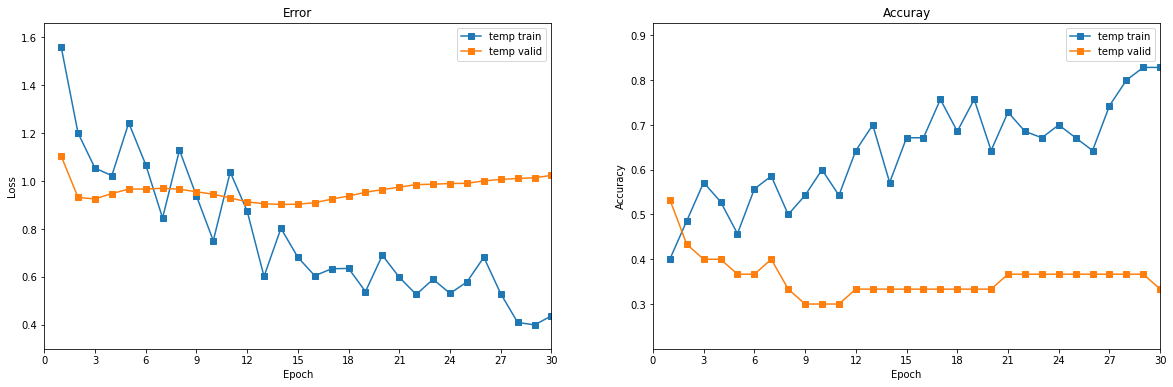

In [15]:
_T.plot_loss_and_acc({"temp train": [train_loss_set, train_acc_set], \
                    "temp valid": [valid_loss_set, valid_acc_set]})

In [16]:
log = pd.DataFrame([train_loss_set, train_acc_set, valid_loss_set, valid_acc_set], index=['train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
log.to_csv(setting.TRAIN.LOG_SAVE_FILE)

In [17]:
logs = pd.read_csv(setting.TRAIN.LOG_SAVE_FILE, index_col=0).T

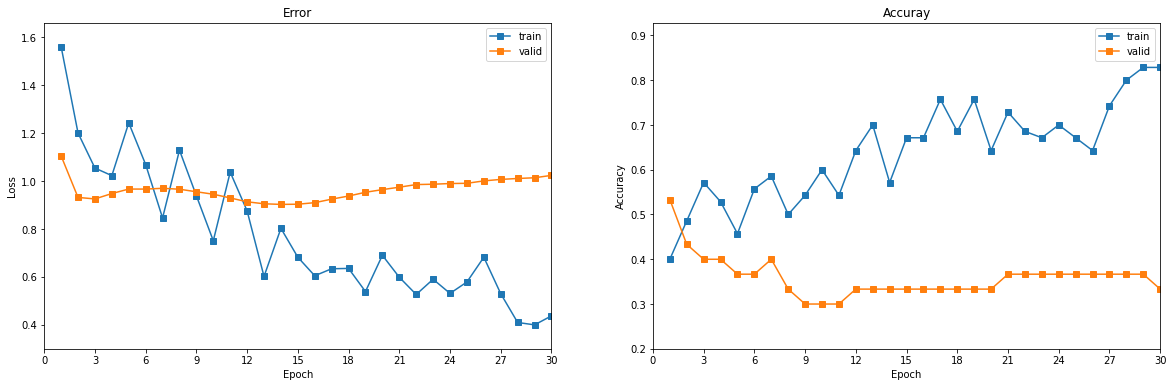

In [19]:
_T.plot_loss_and_acc({"train": [logs['train_loss'], logs['train_acc']], \
                    "valid": [logs['valid_loss'], logs['valid_acc']]})

## Test

In [20]:
model_best =  _M.CNN20d()
model_best.to(device)

# Load Model
state_dict = torch.load(setting.TRAIN.MODEL_SAVE_FILE)
model_best.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
criterion = nn.BCELoss()
_TE.model_test(model_best, setting.TRAIN.LABEL, ['down', 'up'], criterion, setting)

## Inference

In [ ]:
up_factors = _I.model_inference(model_best, setting)